In [17]:
from modelData import ModelData
from boltz.boltzmannEq import boltz, computeCollisionTerms,computeDecayTerms
from scipy.integrate import solve_ivp,odeint
import numpy as np
from matplotlib import pyplot as plt
from tools.configParserWrapper import ConfigParserExt
import os
from tools.logger import setLogLevel

### Load input parameters

In [18]:
parfile = './input_parameters.ini'
parser = ConfigParserExt(inline_comment_prefixes="#")   
ret = parser.read(parfile)
parser = parser.expandLoops()[0]
parserDict = parser.toDict(raw=False)

In [19]:
pars = parser['SolverParameters']
atol = pars['atol']
rtol = pars['rtol']
T0 = pars['T0']
Tf = pars['Tf']
method = pars['method']
nsteps = pars['nsteps']
outputFolder = os.path.abspath(parser['Options']['outputFolder'])
paramCard = os.path.join(outputFolder,'Cards','param_card.dat')
sigmaVFile = os.path.join(outputFolder,'output','taacs.csv')
dm = parser['Model']['darkmatter']
bsmList = str(parser['Model']['bsmParticles']).split(',')
model = ModelData(dmPDG=dm, bsmPDGList=bsmList, paramCard=paramCard, sigmaVfile=sigmaVFile)
    

compDict = model.componentsDict
mDM = compDict[model.dmPDG].mass
x0 = mDM/T0
xf = mDM/Tf    


In [20]:
# Set initila conditions
initialCond = pars['initialConditions']    
y0 = np.zeros(len(model.componentsDict))
for label,comp_y0 in initialCond.items():
    pdg = model.convert2PDG(label)
    comp = compDict[pdg]
    if isinstance(comp_y0,float):
        y0[comp.ID] = y0
    elif comp_y0.lower() in ['eq', 'equilibrium']:
        y0[comp.ID] = comp.Yeq(T0)
    
xvals = np.linspace(x0,xf,nsteps)

In [21]:
# Initial conditions
x0, xf = 1.0,5.0
setLogLevel('info')

### Check terms in initial conditions

In [22]:
for comp in compDict.values():
    print(comp,y0[comp.ID],comp.Yeq(mDM/x0))

SM 0.0 0.27765663383153705
b1 0.015605993470625036 0.010390249138027604
xd 0.007802996735312518 0.00703162087592441


In [23]:
coll = computeCollisionTerms(x0,y0,model)
dec = computeDecayTerms(x0,y0,model)
print(coll)
print(dec)

[{}, {'b1xd_gb': np.float64(-1.1084677850270973e-18), 'b1xxdx_gbx': np.float64(-1.1084677850270973e-18), 'b1xd_ab': np.float64(-1.1084677850270973e-18), 'b1xxdx_abx': np.float64(-1.1084677850270973e-18), 'b1xd_bz': np.float64(-1.1084677850270973e-18), 'b1xxdx_bxz': np.float64(-1.1084677850270973e-18), 'b1xd_twm': np.float64(-1.1084677850270973e-18), 'b1xxdx_txwp': np.float64(-1.1084677850270973e-18), 'b1b1x_bbx': np.float64(-4.141517282649277e-13), 'b1b1_bb': np.float64(-4.141517282649277e-13), 'b1xb1x_bxbx': np.float64(-4.141517282649277e-13), 'b1b1x_gg': np.float64(-4.141517282649277e-13), 'b1b1x_wpwm': np.float64(-4.141517282649277e-13), 'b1b1x_ga': np.float64(-4.141517282649277e-13), 'b1b1x_gz': np.float64(-4.141517282649277e-13), 'b1b1x_aa': np.float64(-4.141517282649277e-13), 'b1b1x_az': np.float64(-4.141517282649277e-13), 'b1b1x_ddx': np.float64(-4.141517282649277e-13), 'b1b1x_uux': np.float64(-4.141517282649277e-13), 'b1b1x_ssx': np.float64(-4.141517282649277e-13), 'b1b1x_ccx':

In [24]:
for process in model.collisionProcesses:
    sigma = process.sigmaV(x0)
    print(f'Process {process.name} : sigmav = {sigma}')

Process xdxdx_bbx : sigmav = 1.9113e-21
Process xdxdx_ttx : sigmav = 1.9113e-21
Process xdxdx_b1b1x : sigmav = 0.0
Process b1xd_gb : sigmav = 9.1027e-15
Process b1xxdx_gbx : sigmav = 9.1027e-15
Process b1xd_ab : sigmav = 9.1027e-15
Process b1xxdx_abx : sigmav = 9.1027e-15
Process b1xd_bz : sigmav = 9.1027e-15
Process b1xxdx_bxz : sigmav = 9.1027e-15
Process b1xd_twm : sigmav = 9.1027e-15
Process b1xxdx_txwp : sigmav = 9.1027e-15
Process b1b1x_bbx : sigmav = 1.7005e-09
Process b1b1_bb : sigmav = 1.7005e-09
Process b1xb1x_bxbx : sigmav = 1.7005e-09
Process b1b1x_gg : sigmav = 1.7005e-09
Process b1b1x_wpwm : sigmav = 1.7005e-09
Process b1b1x_ga : sigmav = 1.7005e-09
Process b1b1x_gz : sigmav = 1.7005e-09
Process b1b1x_aa : sigmav = 1.7005e-09
Process b1b1x_az : sigmav = 1.7005e-09
Process b1b1x_ddx : sigmav = 1.7005e-09
Process b1b1x_uux : sigmav = 1.7005e-09
Process b1b1x_ssx : sigmav = 1.7005e-09
Process b1b1x_ccx : sigmav = 1.7005e-09
Process b1b1x_ttx : sigmav = 1.7005e-09
Process b1b

### Solve equations

In [48]:

#solving the Boltzmann equation
# sol = solve_ivp(boltz, [x0,xf], y0, args=(model,), atol = atol, rtol = rtol, method='LSODA')


from scipy import integrate
ode15s = integrate.ode(boltz)
ode15s.set_integrator('vode', method='bdf', order=15)
ode15s.set_initial_value(y0, x0)
ode15s.set_f_params(model)

Yf_sol = [y0]
xvals = np.linspace(x0,xf,100)
for x in xvals[1:]:
    print(x)
    Yf_sol.append(ode15s.integrate(x))
Yf_sol = np.array(Yf_sol).transpose()

1.0404040404040404
 DVODE--  Warning..internal T (=R1) and H (=R2) are
       such that in the machine, T + H = T on the next step  
       (H = step size). solver will continue anyway
      In above,  R1 =  0.1000000000001D+01   R2 =  0.1061119646234D-15
 DVODE--  Warning..internal T (=R1) and H (=R2) are
       such that in the machine, T + H = T on the next step  
       (H = step size). solver will continue anyway
      In above,  R1 =  0.1000000000001D+01   R2 =  0.1061119646234D-15
 DVODE--  Above warning has been issued I1 times.  
       it will not be issued again for this problem
      In above message,  I1 =         2
1.0808080808080809
 DVODE--  Warning..internal T (=R1) and H (=R2) are
       such that in the machine, T + H = T on the next step  
       (H = step size). solver will continue anyway
      In above,  R1 =  0.1000000000001D+01   R2 =  0.9529911558818D-19
1.121212121212121
 DVODE--  At T (=R1) and step size H (=R2), the    
       corrector convergence failed r

In [49]:
# sol.y.shape
Yf_sol.shape

(3, 100)

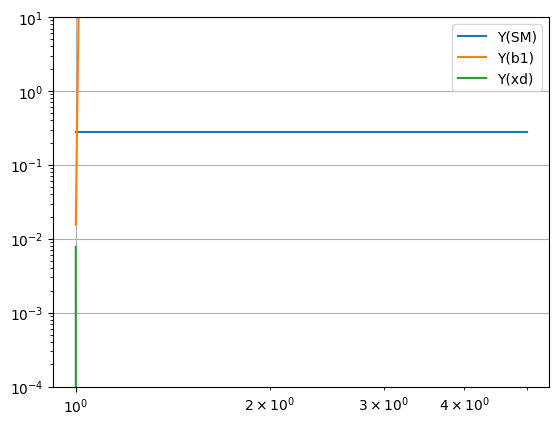

In [51]:
for comp in compDict.values():
    # plt.plot(sol.t,sol.y[comp.ID,:],label=f'Y({comp.label})')
    plt.plot(xvals,Yf_sol[comp.ID,:],label=f'Y({comp.label})')

plt.legend()
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-10,1e-1)
plt.ylim(1e-4,10)
plt.grid()
# plt.title(r'$Y_{f} = $%1.3e (from dYdx), %1.3e (from dGdx)' %(Y_sol0[-1][0],Y_sol[-1][0]))
plt.show()

In [54]:
Yf_sol[2,:]

array([ 0.007803 , -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337435,
       -0.1337435, -0.1337435, -0.1337435, -0.1337435, -0.1337